***Voter Inequality in Canada***

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Define some helper functions for parsing the 308.com data

In [2]:
def read_file(filename):
    f = open(filename, 'r')
    abc = f.readlines()
    f.close()
    return abc

def tab_separate(contents):
    xyz = []
    for a in contents:
        b = a.split("\t")
        xyz.append(b)
    return xyz

def remove_non_data_lines(sep_contents):
    a1 = []
    for x in sep_contents:
        if len([y for y in x if y == '']) < 2:
            a1.append(x)
    return a1

def get_riding_names(clean_contents):
    ridings = []
    for i in range(338):
        ridings.append(clean_contents[i*3+1][0])
    return ridings

Parse the 308.com data

In [3]:
abc = read_file('current_projections.txt')
xyz = tab_separate(abc)
a1 = remove_non_data_lines(xyz)
ridings = get_riding_names(a1)

In [4]:
import fednum_dict as fed

In [5]:
a2 = {v: k for k, v in fed.fednum_dict.items()} 

Manually set some ridings that are difficult to get automatically

In [6]:
found = {}
found['Haliburton – Kawaratha Lakes – Brock'] = 35034
found['Ahuntsic – Cartierville'] = 24003
found['Laval-Les \xceles'] = 24040 
found['Mont-Royal'] = 24052 
found["Ville-Marie – Le Sud-Ouest – L'Île-des-Soeurs"] = 24077 
found["Beauport – Côte-de-Beaupré – Île d'Orléans – Charlevoix"] = 24020
found['Portneuf – Jacques Cartier'] = 24058
found["South Shore – St. Margaret's"] = 12009

In [7]:
not_found = []
for r in ridings:
    if r not in found:
        if r in a2:
            #Riding is easily found in the 308.com data, add to dictionary
            found[r] = a2[r]
        else:
            #Try stripping astrix
            new = r.strip('*')
            if new in a2:
                found[r] = a2[new]
            else:
                #Failed to find the riding
                not_found.append(r)

Some sanity checking for the parsing

In [8]:
len(not_found)

0

In [9]:
len(found)

338

In [10]:
len(not_found)

0

In [11]:
len(set(found.keys()))

338

In [12]:
len(set(found.values()))

338

ridingForecast.py contains some classes for storing party forecasts and riding forecasts

In [13]:
import ridingForecast

In [14]:
ridingDict = ridingForecast.parseCleanForecasts(a1)

In [15]:
print(ridingDict['Mont-Royal'])

Mont-Royal
Winner: ('Liberal', 47.6) prob: 0.73

Conservative Party, low = 35.7, forecast = 37.5, high = 41.3
Liberal Party, low = 42.9, forecast = 47.6, high = 51.0
New Democratic Party, low = 10.2, forecast = 10.6, high = 11.5
Bloc Quebecois Party, low = 1.7, forecast = 1.9, high = 2.0
Green Party, low = 1.9, forecast = 2.1, high = 2.3
Other Party, low = 0.1, forecast = 0.2, high = 0.3


In [16]:
ridingDict['Mont-Royal'].print308()

Low / Bas     35.7     42.9    10.2    1.7     1.9     0.1
Mont-Royal     37.5     47.6    10.6    1.9     2.1     0.2     73.0%
High / Haut     41.3     51.0    11.5    2.0     2.3     0.3


In [17]:
#Make sure all the ridings are in the dictionary
all([r in ridingDict for r in ridings])

True

Read in the Statistics Canada population data for the ridings

In [18]:
populations = pd.read_csv('ridingPopulations.csv')
populations.head()

,Riding,RidingName,Population
0,10001,Avalon,81540
1,10002,Bonavista–Burin–Trinity,76704
2,10003,Coast of Bays–Central–Notre Dame,78092
3,10004,Labrador,26728
4,10005,Long Range Mountains,87592


In [19]:
for riding in ridings:
    ridingDict[riding].population = float(populations[populations['Riding'] == found[riding]]['Population'])

The function for the value of a vote assumes that a voter forecast to cast a tie breaking vote in a riding has value 1.0. The value of other votes is 1.0 divided by the number of times they would need to vote for their party to win.

In [20]:
def voteValue(partyName, ridingFC):
    if partyName == ridingFC.getWinner()[0]:
        delta = ridingFC.getForecast(partyName) - ridingFC.getSecond()[1]
    else:
        delta = ridingFC.getWinner()[1] - ridingFC.getForecast(partyName)
    delta = max(0.05, delta)
    return 100.0/max(100.0,ridingFC.population*delta)

In [21]:
conValues = [(riding, voteValue("Conservative", ridingDict[riding])) for riding in ridings]
libValues = [(riding, voteValue("Liberal", ridingDict[riding])) for riding in ridings]
ndpValues = [(riding, voteValue("New Democratic", ridingDict[riding])) for riding in ridings]
blocValues = [(riding, voteValue("Bloc Quebecois", ridingDict[riding])) for riding in ridings]
greenValues = [(riding, voteValue("Green", ridingDict[riding])) for riding in ridings]
otherValues = [(riding, voteValue("Other", ridingDict[riding])) for riding in ridings]
#print(greenValues)
#print(sorted(ndpValues, key=lambda x: x[1]))

In [22]:
print(max(ndpValues, key=lambda x: x[1]))
print(min(ndpValues, key=lambda x: x[1]))

('Halifax', 0.0015420176684384542)
('Battle River – Crowfoot', 1.3807074303046505e-05)


In [23]:
parties = ["Conservative", "Liberal", "New Democratic", "Bloc Quebecois", "Green", "Other"]

In [24]:
totalpop = sum([ridingDict[riding].population for riding in ridings])

Here we create an array containing the voting values of one in one thousand Canadian voters

In [25]:
voterPowers = np.zeros(32647)
i = 0
for riding in ridings:
    for party in parties:
        for person in range(
            int(ridingDict[riding].getForecast(party)/100.0
                *ridingDict[riding].population/1000.0)):
            voterPowers[i] = voteValue(party, ridingDict[riding])
            i += 1
            

The Lorenz curve is a common way of displaying inequality in a distribution. Basically, the plot visually represents statements in the form "the bottom 20% of all households have 10% of the total income.". This function computes the values of the Lorenz curve.

<a href="https://en.wikipedia.org/wiki/Lorenz_curve"> >Lorenz Curve</a>

In [26]:
def Lorenz(values):
    n = len(values)
    assert(n > 0), 'Empty list of values'
    sortedValues = sorted(values) #Sort smallest to largest

    #Find cumulative totals
    cumm = np.zeros(n+1)
    for i in range(n+1):
        cumm[i] = sum(sortedValues[0:(i + 1)])

    #Calculate Lorenz points
    LorenzPoints = [[], []]
    for i in range(1, n + 2):
        x = 100.0 * (i - 1)/n
        y = 100.0 * (cumm[i - 1]/float(cumm[n]))
        LorenzPoints[0].append(x)
        LorenzPoints[1].append(y)
    

    return LorenzPoints

In [27]:
len(voterPowers)

32647

In [28]:
lorenzPoints = Lorenz(voterPowers)

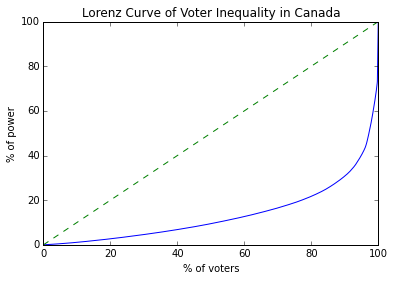

In [29]:
plt.plot(lorenzPoints[0], lorenzPoints[1], [0, 100], [0, 100], '--')
plt.xlabel('% of voters')
plt.ylabel('% of power')
plt.title("Lorenz Curve of Voter Inequality in Canada")
plt.show()

The Gini coefficient is a measure of the inequality represented by the Lorenz curve. It is basically the area between the green dotted line and the blue line, divided by the area under the green dotted line.

<a href="https://en.wikipedia.org/wiki/Gini_coefficient">Gini Coefficient</a>

Canada's wealth inequality Gini Coefficient is about 0.32. South Africa's weath inequality Gini Coefficient is about 0.65, the largest in the world.

In [30]:
def gini(list_of_values):
  """Compute the Gini coefficient given a list of values"""
  sorted_list = sorted(list_of_values)
  height, area = 0, 0
  for value in sorted_list:
    height += value
    area += height - value / 2.
  fair_area = height * len(list_of_values) / 2
  return (fair_area - area) / fair_area

In [31]:
print(gini(voterPowers))

0.730564039236


In [32]:
class voteSwap():
    """                                                                                                  
    Class for holding information about a swap between two ridings                                       
    """
    def	__init__(self, riding1=None, riding2=None, party1=None, party2=None):
        assert riding1 != riding2, "Ridings must be different"
        assert party1 != party2, "Parties must be different"
        self.riding1 = riding1
        self.riding2 = riding2
        self.party1 = party1
        self.party2 = party2
        #Compute the original values of the votes                                                        
        origVal1 = voteValue(self.party1, ridingDict[self.riding1])
        origVal2 = voteValue(self.party2, ridingDict[self.riding2])
        #Compute the new values of the swapped votes                                                     
        # Note that the first voter keeps his preferred party but is                                     
        # effectively voting in the second riding.                                                       
        newVal1 = voteValue(self.party1, ridingDict[self.riding2])
        newVal2 = voteValue(self.party2, ridingDict[self.riding1])
        #Return a tuple consisting of                                                                    
        # 0 - The total increased value because of the swap                                              
        # 1 - The value increase for the first voter                                                     
        # 2 - The value increase for the second voter                                                    
        self.benefit1 = newVal1 / origVal1
        self.benefit2 = newVal2 / origVal2
        self.totalBenefit = self.benefit1*self.benefit2
        
    def __str__(self):
            return "{} voters in {} (gain {}) \nswap with \n{} voters in {} (gain: {}). \nTotal gain: {}".format(
        self.party1, self.riding1, self.benefit1, 
                self.party2, self.riding2, self.benefit2,
                self.totalBenefit)
    def value(self):
        return(self.benefit1*self.benefit2, self.benefit1, self.benefit2)

A few examples:

An NDP voter in Calgary Centre might swap with a Liberal voter in Surrey Centre. These are both swing ridings. Both voters benefit from the transaction.

In [33]:
voteSwap("Calgary Centre", "Surrey Centre", "New Democratic", "Liberal").value()

(6.604166666666661, 5.956444168912548, 1.1087431493330635)

Reversing the above transaction will disadvantage both swappers

In [34]:
voteSwap("Calgary Centre", "Surrey Centre", "Liberal", "New Democratic").value()

(0.1514195583596216, 0.9019221454504812, 0.16788539800626845)

In [35]:
-1.0/voteSwap("Calgary Centre", "Surrey Centre", "Liberal", "New Democratic").benefit1

-1.1087431493330635

In [36]:
voteSwap("Calgary Centre", "Vancouver Quadra", "Liberal", "Conservative").value()

(1.0, 0.10614018534655946, 9.42150229656081)

A Liberal voter in the Liberal safe riding of Vancouver Quadra may wish to send their vote to the swing riding Calgary Centre where it will have more influence. What if they swap with a NDP voter in that riding? The Liberal voter sees a large benefit, while the NDP voter sees a small disadvantage. The net gain in vote value is positive, but will the NDP voter agree to this for the greater good?

In [37]:
voteSwap("Calgary Centre", "Vancouver Quadra", "New Democratic", "Liberal").value()

(5.8286314984709415, 0.6186520275645003, 9.42150229656081)

Let's loop through all possible swaps and compute the value of each swap

In [38]:
import itertools as it
swaps = list()
for item in it.product(ridings, ridings, parties, parties):
    if item[0] != item[1] and item[2] != item[3]:
        if any([party.partyName == item[2] and party.high > 0.0 for party in ridingDict[item[0]].partyList]) and any([party.partyName == item[3] and party.high > 0.0 for party in ridingDict[item[1]].partyList]):
            swaps.append(voteSwap(item[0], item[1], item[2], item[3]))

Now, we will generate a sorted list of all the swaps

In [39]:
sortedSwaps = sorted(swaps, key=lambda x: x.benefit1*x.benefit2, reverse=True)
for swap in sortedSwaps[0:20:2]:
    print(swap)
    print("")

New Democratic voters in Calgary Confederation (gain 37.75000346953999) 
swap with 
Conservative voters in Halifax (gain: 528.7492418481906). 
Total gain: 19960.285714285837

Liberal voters in Kamloops – Thompson – Cariboo (gain 589.9862056626558) 
swap with 
New Democratic voters in Calgary Confederation (gain: 29.483498047754924). 
Total gain: 17394.85714285725

New Democratic voters in Calgary Confederation (gain 35.67008589350394) 
swap with 
Conservative voters in Alfred-Pellan (gain: 371.8842420718342). 
Total gain: 13265.142857142937

New Democratic voters in Calgary Confederation (gain 18.22441772258386) 
swap with 
Liberal voters in Charlesbourg – Haute-Saint-Charles (gain: 497.31250167732696). 
Total gain: 9063.230769230793

New Democratic voters in Calgary Confederation (gain 10.587412953354006) 
swap with 
Conservative voters in Parkdale – High Park (gain: 597.9828062799123). 
Total gain: 6331.090909090923

Liberal voters in Kootenay – Columbia (gain 537.0547211164287) 
swa

In [40]:
partyColours = {'New Democratic': '#F78320', 'Conservative': '#263893', 'Liberal': '#D71921',
                     'Green': '#3D9B35', 'Bloc Quebecois': '#00A7EC', 'Other': 'grey'}
def plotSwap(swap):
    ben1 = swap.benefit1
    if ben1 < 1.0:
        ben1 = -1.0/ben1
    ben2 = swap.benefit2
    if ben2 < 1.0:
        ben2 = -1.0/ben2
        
    fig = plt.figure(1)
    plt.bar([1,2], 
            height=[ben1, ben2], 
            width=0.66, 
            color=[partyColours[swap.party1], partyColours[swap.party2]])
    ax = fig.add_subplot(111)
    ax.text(1.3,max(ben1, ben2)*(1.0 + 0.3),
            swap.party1 + " voter in\n" + swap.riding1, 
            ha="center", 
            va="center", 
            size=10, 
            bbox=dict(boxstyle="round", 
                      fc=partyColours[swap.party1], 
                      ec="0.5",
                      alpha=0.9))
    ax.text(2.5,max(ben1, ben2)*(1.0 + 0.3),
            swap.party2 + " voter in\n" + swap.riding2, 
            ha="center", 
            va="center", 
            size=10, 
            bbox=dict(boxstyle="round", 
                      fc=partyColours[swap.party2], 
                      ec="0.5",
                      alpha=0.9))
    ax.text(1.93,max(ben1, ben2)*(1 + 0.25),
            "swaps with", 
            ha="center", 
            va="center", 
            size=9, 
            bbox=dict(boxstyle="larrow", 
                      fc=partyColours[swap.party1], 
                      ec="0.5",
                      alpha=0.9))
    ax.text(1.93,max(ben1, ben2)*(1 + 0.35),
            "swaps with", 
            ha="center", 
            va="center", 
            size=9, 
            bbox=dict(boxstyle="rarrow", 
                      fc=partyColours[swap.party2], 
                      ec="0.5",
                      alpha=0.9))
    betterWorse = {1.0:"better", -1.0:"worse"}
    ax.text(2.3,0.0,
            "{}X {} off".format(np.round(np.abs(ben2),1), 
                                betterWorse[np.sign(ben2)]), 
            ha="center", 
            va="center", 
            size=12, 
            bbox=dict(boxstyle="round", 
                      fc="white", 
                      ec="0.5",
                      alpha=0.8))
    ax.text(1.3,0.0,
            "{}X {} off".format(np.round(np.abs(ben1),1), 
                                betterWorse[np.sign(ben1)]), 
            ha="center", 
            va="center", 
            size=12, 
            bbox=dict(boxstyle="round", 
                      fc="white", 
                      ec="0.5",
                      alpha=0.8))
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.axhline(y=0,color="black")
    plt.show()

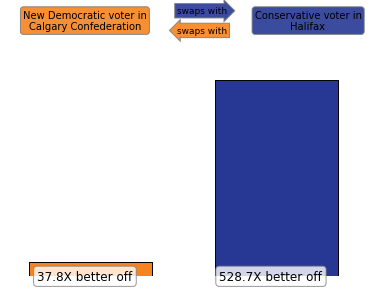

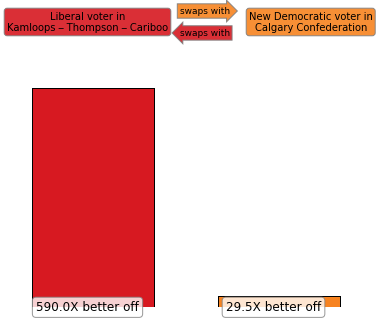

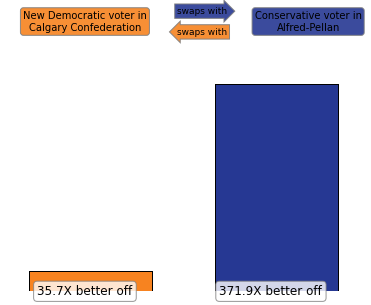

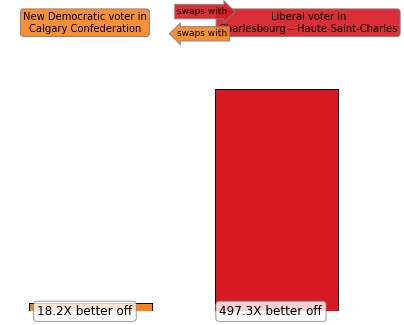

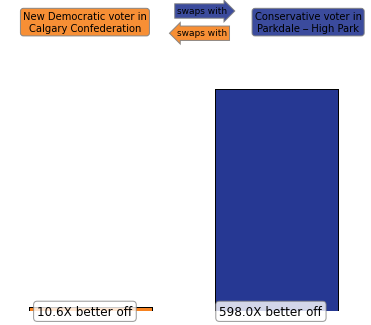

In [41]:
for swap in sortedSwaps[0:10:2]:
    plotSwap(swap)

In [42]:
len(sortedSwaps)

2176472

In [43]:
def topSwaps(riding, party, n=10):
    validSwaps = list()
    for swap in swaps:
        if swap.riding1 == riding and swap.party1 == party:
            validSwaps.append(swap)
    sortedSwaps = sorted(validSwaps, key=lambda x: x.benefit1*x.benefit2, reverse=True) 
    return sortedSwaps[0:n]
    

In [44]:
from IPython.html import widgets
from IPython.display import display


ridingDrop = widgets.Select(options=sorted(ridingDict))
display(ridingDrop)
print("Choose your riding from the box")

Choose your riding from the box


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [45]:

partyDrop = widgets.Dropdown(options=sorted(parties))
display(partyDrop)
print("Choose your preferred party from the box")

Choose your preferred party from the box


In [46]:
for swap in topSwaps(ridingDrop.selected_label, partyDrop.selected_label,5):
    plotSwap(swap)

Compute the strategic costs of voting your conscience

In [51]:
voteValue("Liberal", ridingDict["Calgary Confederation"])/voteValue("New Democratic", ridingDict["Calgary Confederation"])

438.00000000000006

In [52]:
voteValue("Liberal", ridingDict["Calgary Confederation"])/voteValue("Green", ridingDict["Calgary Confederation"])

661.9999999999999